# SWAN procedural example

In this notebook we will use the SWAN Components and data objects to define a SWAN workspace

In [1]:
%load_ext autoreload
%autoreload 2

import shutil
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from cartopy import crs as ccrs

import warnings
warnings.filterwarnings('ignore')

## Workspace basepath

In [2]:
workdir = Path("example_procedural")
shutil.rmtree(workdir, ignore_errors=True)
workdir.mkdir()

## Model Grid

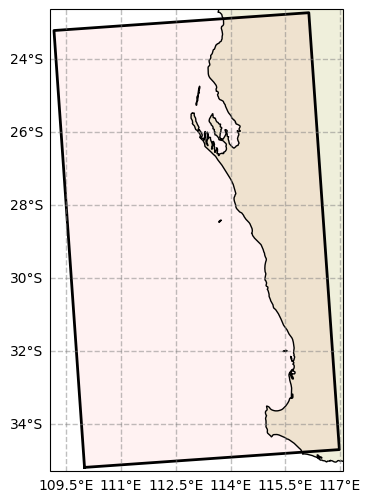

In [3]:
from rompy.swan.grid import SwanGrid

grid = SwanGrid(
    x0=110.0,
    y0=-35.2,
    rot=4.0,
    dx=0.5,
    dy=0.5,
    nx=15,
    ny=25,
)

fig, ax = grid.plot(fscale=6)

## Work with existing data

We will work with subsets of global bathymetry from Gebco and winds from ERA5 available in Rompy. This exercise assumes any processing to the raw forcing data is done with tools outside rompy to handle interpolation or any other required data manipulation.

In [4]:
from rompy.core.types import DatasetCoords
from rompy.core.data import SourceDataset
from rompy.swan.data import SwanDataGrid

In [5]:
DATADIR = Path("../../tests/data")
sorted(DATADIR.glob("*"))

[PosixPath('../../tests/data/aus-20230101.nc'),
 PosixPath('../../tests/data/catalog.yaml'),
 PosixPath('../../tests/data/era5-20230101.nc'),
 PosixPath('../../tests/data/gebco-1deg.nc')]

In [6]:
def my_fancy_interpolation(
    dset: xr.Dataset,
    grid: SwanGrid,
    coords: DatasetCoords,
    buffer: float = 0.0,
) -> xr.Dataset:
    """Dummy interpolation function."""
    x0, y0, x1, y1 = grid.bbox(buffer)
    xarr = np.arange(x0, x1+grid.dx, grid.dx)
    yarr = np.arange(y0, y1+grid.dy, grid.dy)
    return dset.interp(**{coords.x: xarr, coords.y: yarr})

### Bathy

In [7]:
# Open the global dataset

gebco = xr.open_dataset(DATADIR / "gebco-1deg.nc")
gebco

<xarray.Dataset>
Dimensions:    (lat: 181, lon: 360)
Coordinates:
  * lon        (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * lat        (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89 90
Data variables:
    elevation  (lat, lon) float64 ...
Attributes:
    title:    Subset of the GEBCO 2020 grid for testing purposes

In [8]:
# Process it into the model bathy

dset = my_fancy_interpolation(gebco, grid, DatasetCoords(x="lon", y="lat"), buffer=1.0)
dset

<xarray.Dataset>
Dimensions:    (lat: 30, lon: 21)
Coordinates:
  * lon        (lon) float64 108.2 108.7 109.2 109.7 ... 116.7 117.2 117.7 118.2
  * lat        (lat) float64 -36.2 -35.7 -35.2 -34.7 ... -23.2 -22.7 -22.2 -21.7
Data variables:
    elevation  (lat, lon) float64 -5.443e+03 -5.552e+03 ... 333.9 346.7
Attributes:
    title:    Subset of the GEBCO 2020 grid for testing purposes

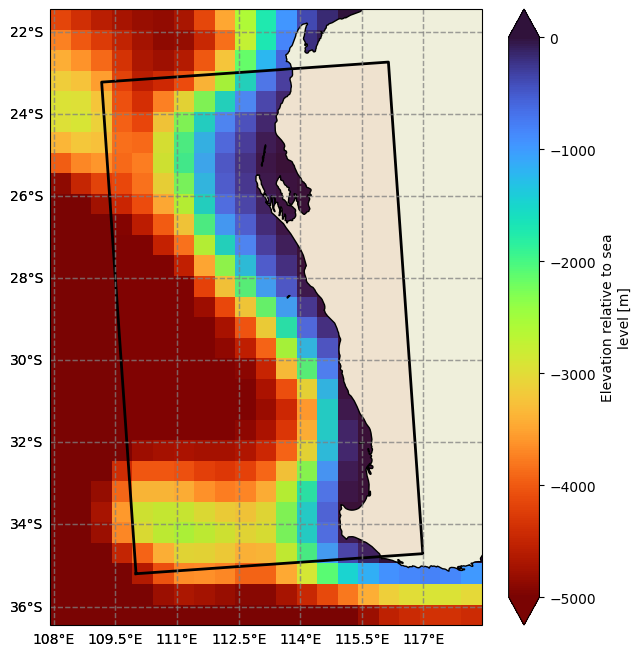

In [9]:
# Create and plot the data instance

bottom = SwanDataGrid(
    var="bottom",
    source=SourceDataset(obj=dset),
    z1="elevation",
    fac=-1,
    coords={"x": "lon", "y": "lat"},
    crop_grid=False, # So data isn't cropped to model grid inside SwanConfig
)

fig, ax = bottom.plot(param="elevation", vmin=-5000, vmax=0, cmap="turbo_r", figsize=(7, 8))
fig, ax = grid.plot(ax=ax)

### Winds

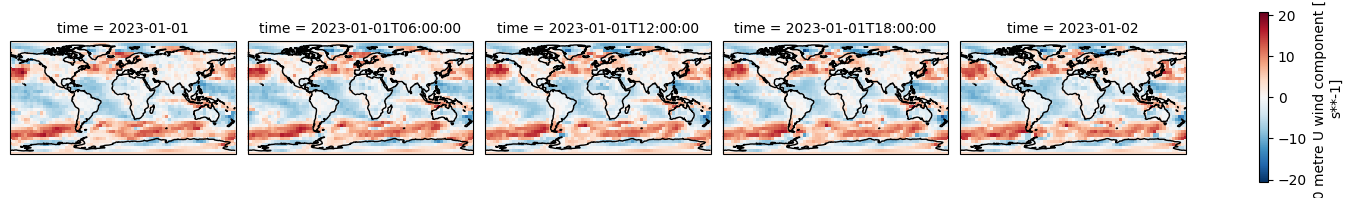

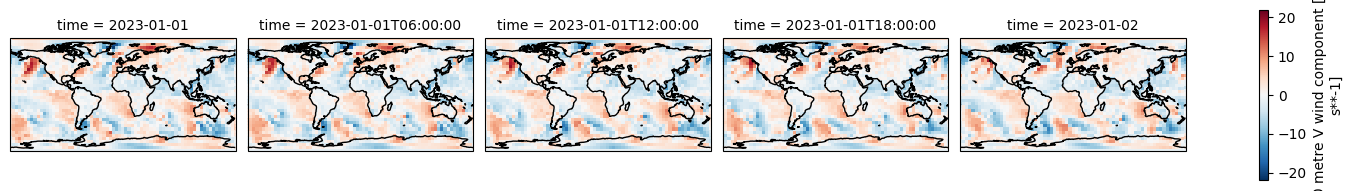

In [10]:
# Open the global dataset

projection = ccrs.PlateCarree()

era5 = xr.open_dataset(DATADIR / "era5-20230101.nc")
fu = era5.u10.plot(col="time", figsize=(15, 2), subplot_kws={"projection": projection})
fv = era5.v10.plot(col="time", figsize=(15, 2), subplot_kws={"projection": projection})
for f in [fu, fv]:
    f.map(lambda: plt.gca().coastlines())

In [11]:
# Process it into the model forcing

dset = my_fancy_interpolation(era5, grid, DatasetCoords(x="longitude", y="latitude"), buffer=1.0)
dset

<xarray.Dataset>
Dimensions:    (time: 5, latitude: 30, longitude: 21)
Coordinates:
  * time       (time) datetime64[ns] 2023-01-01 ... 2023-01-02
  * longitude  (longitude) float64 108.2 108.7 109.2 109.7 ... 117.2 117.7 118.2
  * latitude   (latitude) float64 -36.2 -35.7 -35.2 -34.7 ... -22.7 -22.2 -21.7
Data variables:
    u10        (time, latitude, longitude) float64 3.054 3.084 ... 2.082 1.339
    v10        (time, latitude, longitude) float64 4.884 4.951 ... 1.778 0.9003
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-10 00:03:38 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

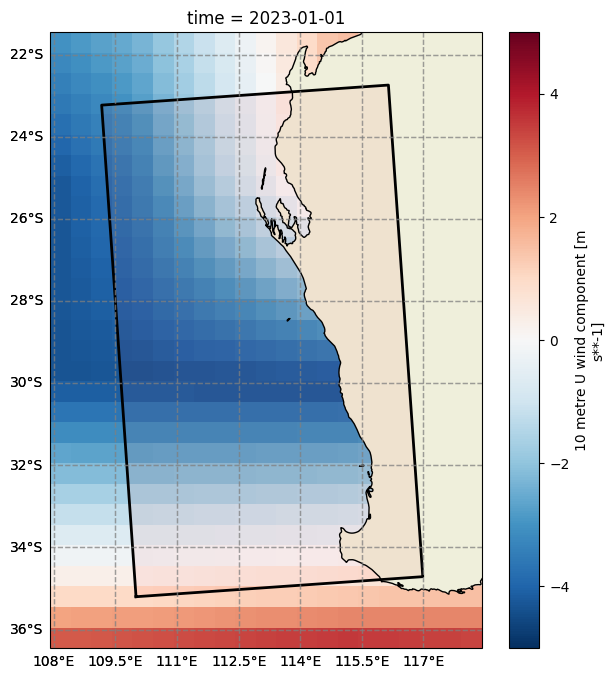

In [12]:
# Create the data instance

wind = SwanDataGrid(
    var="wind",
    source=SourceDataset(obj=dset),
    z1="u10",
    z2="v10",
    coords={"x": "longitude", "y": "latitude"},
    crop_grid=False, # So data isn't cropped to model grid inside SwanConfig
)

fig, ax = wind.plot(param="u10", isel={"time": 0}, vmin=-5, vmax=5, cmap="RdBu_r", figsize=(7, 8))
fig, ax = grid.plot(ax=ax)

###  Boundary

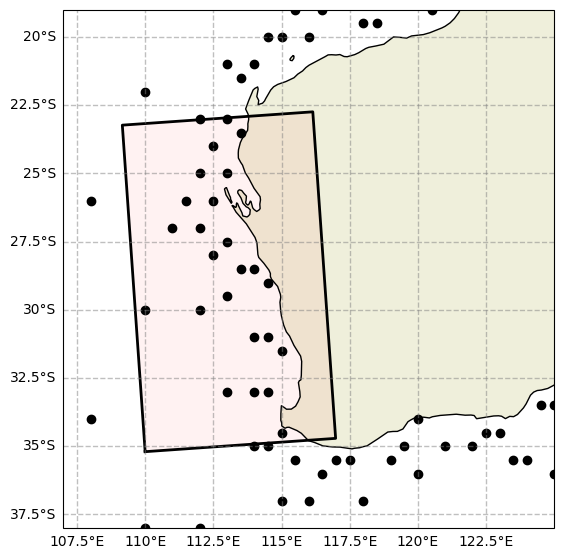

In [31]:
from rompy.swan.boundary import BoundspecSide
from rompy.core.data import SourceFile

bnd = BoundspecSide(
    id="westaus",
    source=SourceFile(
        uri=DATADIR / "aus-20230101.nc",
        kwargs=dict(engine="netcdf4"),
    ),
    sel_method="nearest",
    sel_method_kwargs={"tolerance": 2.0},
    location={"side": "west"},
)
bnd

# Plot spectra locations to check
fig, ax = grid.plot()
ax.plot(bnd.ds.lon, bnd.ds.lat, "ok")
ax.set_extent([107, 125, -38, -19])

## SWAN components

SWAN commands can be fully prescribed using what we define as "Components". Components
are pydantic objects that describe the different sets of command instruction in SWAN
with fields that matching command options and a `render()` method that returns the
string to render in the `INPUT` command file.

The `SwanConfigComponents` config class takes the components as fields organised as
"group" components, a collection of individual components that are defined together and
validated for consistency. These groups are structured similarly to the main groups of
SWAN commands as defined by the subsections in
[Chapter 4](https://swanmodel.sourceforge.io/online_doc/swanuse/node20.html) of the user manual. 

In [16]:
from rompy.swan.config import SwanConfigComponents

SwanConfigComponents?

Init signature:
SwanConfigComponents(
    *,
    model_type: Literal['swanconfig', 'SWANCONFIG'] = 'swanconfig',
    template: str = '/source/csiro/rompy/rompy/templates/swancomp',
    checkout: Optional[str] = 'main',
    cgrid: Union[rompy.swan.components.cgrid.REGULAR, rompy.swan.components.cgrid.CURVILINEAR, rompy.swan.components.cgrid.UNSTRUCTURED],
    startup: Optional[Annotated[rompy.swan.components.group.STARTUP, FieldInfo(annotation=NoneType, required=True, description='Startup components')]] = None,
    inpgrid: Optional[Annotated[Union[rompy.swan.components.group.INPGRIDS, rompy.swan.interface.DataInterface], FieldInfo(annotation=NoneType, required=True, description='Input grid components', discriminator='model_type')]] = None,
    boundary: Optional[Annotated[Union[rompy.swan.components.boundary.BOUNDSPEC, rompy.swan.components.boundary.BOUNDNEST1, rompy.swan.components.boundary.BOUNDNEST2, rompy.swan.components.boundary.BOUNDNEST3, rompy.swan.interface.BoundaryInterface],

### CGRID

In [17]:
from rompy.swan.components.cgrid import REGULAR
from rompy.swan.subcomponents.readgrid import GRIDREGULAR
from rompy.swan.subcomponents.spectrum import SPECTRUM

cgrid = REGULAR(
    grid=grid.component,
    spectrum=SPECTRUM(mdc=36, flow=0.04, fhigh=1.0)
)

print(cgrid.render())

CGRID REGULAR xpc=110.0 ypc=-35.2 alpc=4.0 xlenc=7.0 ylenc=12.0 mxc=14 myc=24 CIRCLE mdc=36 flow=0.04 fhigh=1.0


### Startup

In [18]:
from rompy.swan.components.group import STARTUP
from rompy.swan.components.startup import PROJECT, SET, MODE, COORDINATES
from rompy.swan.subcomponents.startup import SPHERICAL

project = PROJECT(
    name="Test procedural",
    nr="run1",
    title1="Procedural definition of a Swan config with rompy",
)

set = SET(level=0.0, depmin=0.05, direction_convention="nautical")

mode = MODE(kind="nonstationary", dim="twodimensional")

coordinates = COORDINATES(kind=SPHERICAL())

startup = STARTUP(
    project=project,
    set=set,
    mode=mode,
    coordinates=coordinates,
)

print(startup.render())

PROJECT name='Test procedural' nr='run1' title1='Procedural definition of a Swan config with rompy'

SET level=0.0 depmin=0.05 NAUTICAL

MODE NONSTATIONARY TWODIMENSIONAL

COORDINATES SPHERICAL CCM


### Initial conditions

Components are available to represent the different initial conditions options in SWAN
including `DEFAULT`, `ZERO`, `PAR` and `HOTSTART`

TODO: allow using the `BoundaryInterface` to define initial conditions.

In [19]:
from rompy.swan.components.boundary import INITIAL
from rompy.swan.subcomponents.boundary import DEFAULT

initial = INITIAL(kind=DEFAULT())

print(initial.render())

INITIAL DEFAULT


### Physics

The Components support every SWAN physics command option. They are prescribed in the 
`SwanConfigComponents` using the PHYSICS group component.

In [20]:
from rompy.swan.components.group import PHYSICS
from rompy.swan.components.physics import GEN3, BREAKING_CONSTANT, FRICTION_RIPPLES, QUADRUPL, TRIAD
from rompy.swan.subcomponents.physics import WESTHUYSEN

gen = GEN3(source_terms=WESTHUYSEN(wind_drag="wu", cds2=5.0e-5, br=1.75e-3))

breaking = BREAKING_CONSTANT(alpha=1.0, gamma=0.73)

friction = FRICTION_RIPPLES(s=2.65, d=0.0001)

triad = TRIAD(itriad=1)

quad = QUADRUPL(iquad=2, lambd=0.25, cnl4=3.0e7, csh1=5.5, csh2=0.833, csh3=-1.25)

physics = PHYSICS(
    gen=gen,
    breaking=breaking,
    friction=friction,
    triad=triad,
    quadrupl=quad,
)

print(physics.render())

GEN3 WESTHUYSEN cds2=5e-05 br=0.00175 DRAG WU

QUADRUPL iquad=2 lambda=0.25 cnl4=30000000.0 csh1=5.5 csh2=0.833 csh3=-1.25

BREAKING CONSTANT alpha=1.0 gamma=0.73

FRICTION RIPPLES S=2.65 D=0.0001

TRIAD itriad=1


### Propagation scheme

In [21]:
from rompy.swan.components.numerics import PROP
from rompy.swan.subcomponents.numerics import BSBT

prop = PROP(scheme=BSBT())

print(prop.render())

PROP BSBT


### Numerics

In [22]:
from rompy.swan.components.numerics import NUMERIC
from rompy.swan.subcomponents.numerics import STAT, STOPC, DIRIMPL

stopc = STOPC(dabs=0.02, drel=0.02, curvat=0.02, npnts=98, mode=STAT(mxitst=50))

dirimpl = DIRIMPL(cdd=0.5)

numeric = NUMERIC(stop=stopc, dirimpl=dirimpl)

print(numeric.render())

NUMERIC STOPC dabs=0.02 drel=0.02 curvat=0.02 npnts=98.0 STATIONARY mxitst=50 DIRIMPL cdd=0.5


### Output

Output commands are defined in `SwanConfigComponents` with the `OUTPUT` group component.
Many validations are defined to ensure location and write components are prescribed correctly.

The output write components (and the lockup ones) require times, however we can skip
defining times here as `SwanConfigComponents` will ensure consistent times are
defined for all time-dependant components.  

In [23]:
from rompy.swan.components.group import OUTPUT
from rompy.swan.components.output import POINTS, QUANTITY, QUANTITIES, BLOCK, TABLE, SPECOUT
from rompy.swan.subcomponents.output import SPEC2D, ABS
from rompy.swan.subcomponents.time import TimeRangeOpen

points = POINTS(
    sname="pts",
    xp=[114.0, 112.5, 115.0],
    yp=[-34.0, -26.0, -30.0],
)

q1 = QUANTITY(output=["hsign"], hexp=50.0)
q2 = QUANTITY(output=["hsign", "tps"], fmin=0.04, fmax=0.3)
q3 = QUANTITY(output=["hswell"], fswell=0.125)
quantity = QUANTITIES(quantities=[q1, q2, q3])

block = BLOCK(
    sname="COMPGRID",
    fname="outgrid.nc",
    output=["depth", "wind", "hsign", "hswell", "dir", "tps"],
    times=TimeRangeOpen(tfmt=1, dfmt="min"), # Default times which will be overwritten
    idla=3,
)

table = TABLE(
    sname="pts",
    fname="outpts.txt",
    output=["time", "hsign", "dir", "tps", "tm01"],
    times=TimeRangeOpen(tfmt=1, dfmt="min"), # Default times which will be overwritten
)

specout = SPECOUT(
    sname="pts",
    fname="swanspec.nc",
    dim=SPEC2D(),
    freq=ABS(),
    times=TimeRangeOpen(tfmt=1, dfmt="min"), # Default times which will be overwritten
)

output = OUTPUT(
    points=points,
    quantity=quantity,
    block=block,
    table=table,
    specout=specout,
)

print(output.render())

POINTS sname='pts' &
    xp=114.0 yp=-34.0 &
    xp=112.5 yp=-26.0 &
    xp=115.0 yp=-30.0

QUANTITY HSIGN hexp=50.0

QUANTITY HSIGN TPS fmin=0.04 fmax=0.3

QUANTITY HSWELL fswell=0.125

BLOCK sname='COMPGRID' fname='outgrid.nc' LAYOUT idla=3 &
    DEPTH &
    WIND &
    HSIGN &
    HSWELL &
    DIR &
    TPS &
    OUTPUT tbegblk=19700101.000000 deltblk=60.0 MIN

TABLE sname='pts' fname='outpts.txt' &
    TIME &
    HSIGN &
    DIR &
    TPS &
    TM01 &
    OUTPUT tbegtbl=19700101.000000 delttbl=60.0 MIN

SPECOUT sname='pts' SPEC2D ABS fname='swanspec.nc' OUTPUT tbegspc=19700101.000000 deltspc=60.0 MIN


### Lockup

The lockup components are prescribed to the `SwanConfigComponents` class from the `LOCKUP`
group component. similar to the output components, time-based fields do not need to be
prescribed as they will be reset in the config class, however some time parameters such as
`tfmt` and `dfmt` are maintained if defined so they could be defined here.

In [24]:
from rompy.swan.components.group import LOCKUP
from rompy.swan.components.lockup import COMPUTE_STAT, HOTFILE
from rompy.swan.subcomponents.time import NONSTATIONARY

hotfile = HOTFILE(fname="hotfile.swn", format="free")

compute = COMPUTE_STAT(
    times=NONSTATIONARY(tfmt=1, dfmt="hr"), # We use nonstationary times here to prescribe multiple STAT commands
    hotfile=hotfile,
    hottimes=[1, -1], # Output hotfile after the 2nd and last time steps
)

lockup = LOCKUP(compute=compute)

print(lockup.render())

COMPUTE STATIONARY time=19700101.000000
COMPUTE STATIONARY time=19700101.010000
HOTFILE fname='hotfile_19700101T010000.swn' FREE
COMPUTE STATIONARY time=19700101.020000
COMPUTE STATIONARY time=19700101.030000
COMPUTE STATIONARY time=19700101.040000
COMPUTE STATIONARY time=19700101.050000
COMPUTE STATIONARY time=19700101.060000
COMPUTE STATIONARY time=19700101.070000
COMPUTE STATIONARY time=19700101.080000
COMPUTE STATIONARY time=19700101.090000
COMPUTE STATIONARY time=19700101.100000
COMPUTE STATIONARY time=19700101.110000
COMPUTE STATIONARY time=19700101.120000
COMPUTE STATIONARY time=19700101.130000
COMPUTE STATIONARY time=19700101.140000
COMPUTE STATIONARY time=19700101.150000
COMPUTE STATIONARY time=19700101.160000
COMPUTE STATIONARY time=19700101.170000
COMPUTE STATIONARY time=19700101.180000
COMPUTE STATIONARY time=19700101.190000
COMPUTE STATIONARY time=19700101.200000
COMPUTE STATIONARY time=19700101.210000
COMPUTE STATIONARY time=19700101.220000
COMPUTE STATIONARY time=1970010

## Data interfaces

Input data and boundary objects interface with `SwanConfigComponents` using the `Interface` classes. These classes have a `get` method from which the output
directory, the grid and the time objects can be passed from the config class to each
data or boundary instance.

### Input data interface

In [58]:
from rompy.swan.interface import DataInterface

inpgrid = DataInterface(
    bottom=bottom,
    input=[wind],
)
# inpgrid

### Boundary interface

In [42]:
from rompy.swan.boundary import BoundspecSide, BoundspecSegmentXY
from rompy.swan.subcomponents.boundary import SIDE, SIDES
from rompy.core.data import SourceFile

bndsource = SourceFile(
    uri=DATADIR / "aus-20230101.nc",
    kwargs=dict(engine="netcdf4"),
)
location = SIDES(
    sides=[
        SIDE(side="south", direction="clockwise"),
        SIDE(side="west", direction="clockwise"),
    ],
)

# bnd = BoundspecSide(
#     id="westaus",
#     source=bndsource,
#     sel_method="nearest",
#     sel_method_kwargs={"tolerance": 2.0},
#     location={"side": "west"},
# )

bnd = BoundspecSegmentXY(
    id="westaus",
    source=bndsource,
    sel_method="idw",
    sel_method_kwargs={"tolerance": 3.0},
    location=location,
    spacing=None, # Boundary created at the resolution of the grid object
)

boundary_segment = BoundaryInterface(kind=bnd)
boundary_segment

BoundaryInterface(model_type='boundary_interface', kind=BoundspecSegmentXY(model_type='boundspecside', id='westaus', source=SourceFile(model_type='open_dataset', uri=PosixPath('../../tests/data/aus-20230101.nc'), kwargs={'engine': 'netcdf4'}), filter=Filter(sort={}, subset={}, crop={}, timenorm={}, rename={}, derived={}), variables=[], coords=DatasetCoords(t='time', x='longitude', y='latitude', z='depth'), crop_data=True, buffer=0.0, data_type='data_boundary', spacing=None, sel_method='idw', sel_method_kwargs={'tolerance': 3.0}, grid_type='boundary_wave_station', shapespec=SHAPESPEC(model_type='shapespec', shape=JONSWAP(model_type='jonswap', gamma=3.3), per_type='peak', dspr_type='degrees'), variable=False, file_type='tpar', location=SIDES(model_type='sides', sides=[SIDE(model_type='side', side='south', direction='clockwise'), SIDE(model_type='side', side='west', direction='clockwise')])))

In [ ]:
from rompy.swan.interface import BoundaryInterface

boundary = BoundaryInterface(kind=bnd)
# boundary

### Instantiate config

Note each field is optional so it is possible to skip defining a certain group component
such as `prop` to allow using default options in SWAN.

In [43]:
config = SwanConfigComponents(
    cgrid=cgrid,
    startup=startup,
    inpgrid=inpgrid,
    initial=initial,
    boundary=boundary_segment,
    physics=physics,
    prop=prop,
    numeric=numeric,
    output=output,
    lockup=lockup,
)

### Generate workspace

In [44]:
from rompy.model import ModelRun
from rompy.core.time import TimeRange

start, end = era5.time.to_index()[[0, -1]]

run = ModelRun(
    run_id="run1",
    period=TimeRange(start=start, end=end, interval="1h"),
    output_dir=str(workdir),
    config=config,
)

rundir = run()

INFO:rompy.model:
INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Model settings:
INFO:rompy.model:
run_id: run1
period: 
	Start: 2023-01-01 00:00:00
	End: 2023-01-02 00:00:00
	Duration: 1 days 00:00:00
	Interval: 1:00:00
	Include End: True

output_dir: example_procedural
config: <class 'rompy.swan.config.SwanConfigComponents'>

INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Generating model input files in example_procedural


INFO:rompy.swan.data:	Writing bottom to example_procedural/run1/bottom.grd
INFO:rompy.swan.data:	Writing wind to example_procedural/run1/wind.grd
INFO:rompy.model:
INFO:rompy.model:Successfully generated project in example_procedural
INFO:rompy.model:-----------------------------------------------------


### Check the workspace

In [45]:
modeldir = Path(run.output_dir) / run.run_id

sorted(modeldir.glob("*"))

[PosixPath('example_procedural/run1/Errfile'),
 PosixPath('example_procedural/run1/INPUT'),
 PosixPath('example_procedural/run1/PRINT'),
 PosixPath('example_procedural/run1/bottom.grd'),
 PosixPath('example_procedural/run1/hotfile_20230101T010000.swn'),
 PosixPath('example_procedural/run1/hotfile_20230102T000000.swn'),
 PosixPath('example_procedural/run1/norm_end'),
 PosixPath('example_procedural/run1/outgrid.nc'),
 PosixPath('example_procedural/run1/outpts.txt'),
 PosixPath('example_procedural/run1/swaninit'),
 PosixPath('example_procedural/run1/swanspec.nc'),
 PosixPath('example_procedural/run1/westaus_tpar_000.bnd'),
 PosixPath('example_procedural/run1/westaus_tpar_001.bnd'),
 PosixPath('example_procedural/run1/westaus_tpar_002.bnd'),
 PosixPath('example_procedural/run1/westaus_tpar_003.bnd'),
 PosixPath('example_procedural/run1/westaus_tpar_004.bnd'),
 PosixPath('example_procedural/run1/westaus_tpar_005.bnd'),
 PosixPath('example_procedural/run1/westaus_tpar_006.bnd'),
 PosixPath('

In [46]:
input = modeldir / "INPUT"
print(input.read_text())

! Rompy SwanConfig
! Template: /source/csiro/rompy/rompy/templates/swancomp
! Generated: 2024-02-20 23:36:26.687653 on rafael-XPS by rguedes


! Startup -------------------------------------------------------------------------------------------------------------------------------------------------------------------------

PROJECT name='Test procedural' nr='run1' title1='Procedural definition of a Swan config with rompy'

SET level=0.0 depmin=0.05 NAUTICAL

MODE NONSTATIONARY TWODIMENSIONAL

COORDINATES SPHERICAL CCM

! Computational Grid --------------------------------------------------------------------------------------------------------------------------------------------------------------


CGRID REGULAR xpc=110.0 ypc=-35.2 alpc=4.0 xlenc=7.0 ylenc=12.0 mxc=14 myc=24 CIRCLE mdc=36 flow=0.04 fhigh=1.0

! Input Grids ---------------------------------------------------------------------------------------------------------------------------------------------------------------------

I

## Run the model

Redirect to avoid large output

In [47]:
!docker run  -v ./example_procedural/run1:/home oceanum/swan:4141 swan.exe > example_procedural/swan.log
!tail example_procedural/swan.log


 iteration    4; sweep 1
+iteration    4; sweep 2
+iteration    4; sweep 3
+iteration    4; sweep 4
 accuracy OK in 100.00 % of wet grid points ( 98.00 % required)

+SWAN is processing output request    1
+SWAN is processing output request    2
+SWAN is processing output request    3


## Plot outputs

In [48]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from wavespectra import read_ncswan, read_swan
from wavespectra.core.swan import read_tab

pd.set_option("display.notebook_repr_html", False)

In [49]:
sorted(modeldir.glob("*"))

[PosixPath('example_procedural/run1/Errfile'),
 PosixPath('example_procedural/run1/INPUT'),
 PosixPath('example_procedural/run1/PRINT'),
 PosixPath('example_procedural/run1/bottom.grd'),
 PosixPath('example_procedural/run1/hotfile_20230101T010000.swn'),
 PosixPath('example_procedural/run1/hotfile_20230102T000000.swn'),
 PosixPath('example_procedural/run1/norm_end'),
 PosixPath('example_procedural/run1/outgrid.nc'),
 PosixPath('example_procedural/run1/outpts.txt'),
 PosixPath('example_procedural/run1/swaninit'),
 PosixPath('example_procedural/run1/swanspec.nc'),
 PosixPath('example_procedural/run1/westaus_tpar_000.bnd'),
 PosixPath('example_procedural/run1/westaus_tpar_001.bnd'),
 PosixPath('example_procedural/run1/westaus_tpar_002.bnd'),
 PosixPath('example_procedural/run1/westaus_tpar_003.bnd'),
 PosixPath('example_procedural/run1/westaus_tpar_004.bnd'),
 PosixPath('example_procedural/run1/westaus_tpar_005.bnd'),
 PosixPath('example_procedural/run1/westaus_tpar_006.bnd'),
 PosixPath('

In [50]:
# Gridded output

dsgrid = xr.open_dataset(modeldir / run.config.output.block.fname)
dsgrid

<xarray.Dataset>
Dimensions:    (time: 25, yc: 25, xc: 15)
Coordinates:
  * time       (time) datetime64[ns] 2023-01-01 ... 2023-01-02
    longitude  (yc, xc) float32 ...
    latitude   (yc, xc) float32 ...
Dimensions without coordinates: yc, xc
Data variables:
    depth      (time, yc, xc) float32 ...
    xwnd       (time, yc, xc) float32 ...
    ywnd       (time, yc, xc) float32 ...
    hs         (time, yc, xc) float32 ...
    hswe       (time, yc, xc) float32 ...
    theta0     (time, yc, xc) float32 ...
    tps        (time, yc, xc) float32 ...
Attributes:
    Conventions:             CF-1.5
    History:                 Created with agioncmd version 1.5
    Directional_convention:  nautical
    project:                 Test procedural
    run:                     run1

In [51]:
# Spectra output

dspec = read_ncswan(modeldir / run.config.output.specout.fname)
dspec

<xarray.Dataset>
Dimensions:  (time: 25, site: 3, freq: 35, dir: 36)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01 2023-01-01T01:00:00 ... 2023-01-02
  * freq     (freq) float32 0.04 0.04397 0.04834 0.05314 ... 0.8275 0.9097 1.0
  * dir      (dir) float32 261.0 251.0 241.0 231.0 ... 301.0 291.0 281.0 271.0
  * site     (site) int64 1 2 3
Data variables:
    lon      (site) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    lat      (site) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    efth     (time, site, freq, dir) float32 dask.array<chunksize=(25, 3, 35, 36), meta=np.ndarray>
    dpt      (time, site) float32 dask.array<chunksize=(25, 3), meta=np.ndarray>
    wspd     (time, site) float32 dask.array<chunksize=(25, 3), meta=np.ndarray>
    wdir     (time, site) float32 dask.array<chunksize=(25, 3), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.5
    History:                 Created with agioncmd version 1.5
    Directional_convention:  nautical
    project:                 Test procedural
    model:                   41.41
    run:                     run1

In [52]:
os.system(f"head -n 15 {modeldir / run.config.output.table.fname}")

%
%
% Run:run1  Table:pts               SWAN version:41.41
%
%       Time               Hsig          Dir           TPsmoo        Tm01     
%       [ ]                [m]           [degr]        [sec]         [sec]    
%
20230101.000000           0.0000      -999.000       -9.0000       -9.0000 
20230101.000000           0.0000      -999.000       -9.0000       -9.0000 
20230101.000000          -9.0000      -999.000       -9.0000       -9.0000 
20230101.010000           0.0000      -999.000       -9.0000       -9.0000 
20230101.010000           0.0000      -999.000       -9.0000       -9.0000 
20230101.010000          -9.0000      -999.000       -9.0000       -9.0000 
20230101.020000           0.0000      -999.000       -9.0000       -9.0000 
20230101.020000           0.0000      -999.000       -9.0000       -9.0000 


0

In [53]:
# Timeseries output (keep 1st site only)

df = read_tab(modeldir / run.config.output.table.fname)

df["time"] = df.index
df = df.drop_duplicates("time", keep="first").drop("time", axis=1)
df.head()

                     Hsig    Dir  TPsmoo  Tm01
time                                          
2023-01-01 00:00:00   0.0 -999.0    -9.0  -9.0
2023-01-01 01:00:00   0.0 -999.0    -9.0  -9.0
2023-01-01 02:00:00   0.0 -999.0    -9.0  -9.0
2023-01-01 03:00:00   0.0 -999.0    -9.0  -9.0
2023-01-01 04:00:00   0.0 -999.0    -9.0  -9.0

### Plot model depth

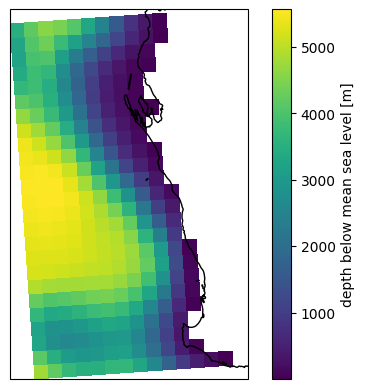

In [54]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
p = dsgrid.depth.isel(time=0, drop=True).plot(ax=ax, x="longitude", y="latitude")
ax.coastlines();

### Plot gridded Hs

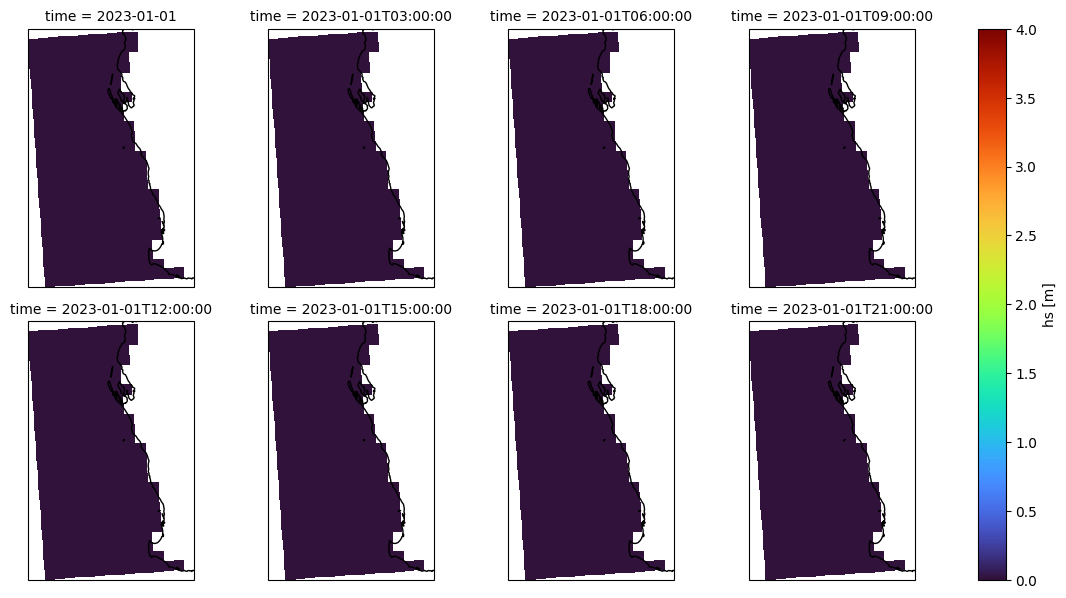

In [55]:
f = dsgrid.hs.isel(time=slice(0, -1, 3)).plot(
    x="longitude",
    y="latitude",
    col="time",
    col_wrap=4,
    vmin=0,
    vmax=4,
    cmap="turbo",
    subplot_kws=dict(projection=ccrs.PlateCarree()),
)
f.map(lambda: plt.gca().coastlines());

### Plot gridded wind

In [ ]:
u = dsgrid.xwnd.isel(time=slice(0, -1, 3))
v = dsgrid.ywnd.isel(time=slice(0, -1, 3))
f = np.sqrt(u ** 2 + v ** 2).plot(
    x="longitude",
    y="latitude",
    col="time",
    col_wrap=4,
    vmin=2,
    vmax=12,
    cmap="jet",
    cbar_kwargs={"label": "Wind speed (m/s)"},
    subplot_kws=dict(projection=ccrs.PlateCarree()),
)
for ax, time in zip(f.axs.flat, u.time):
    ax.coastlines()
    ax.quiver(u.longitude, u.latitude, u.sel(time=time), v.sel(time=time), scale=200)
    ax.plot(dspec.isel(site=0).lon, dspec.isel(site=0).lat, "ok")

### Plot spectra

In [ ]:
p = dspec.isel(site=0, time=slice(0, -1, 3)).spec.plot(col="time", col_wrap=4)

### Plot timeseries

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

df.Hsig.plot(ax=ax1, label="From table", linewidth=5)
dspec.isel(site=0).spec.hs().to_pandas().plot(ax=ax1, label="From spectra")
ax1.set_ylabel("Hs (m)")
ax1.set_ylim([0, 1.5])
l = ax1.legend()

df.TPsmoo.plot(ax=ax2, label="From table", linewidth=5)
dspec.isel(site=0).spec.tp(smooth=True).to_pandas().plot(ax=ax2, label="From spectra")
ax2.set_ylabel("Tp (s)")
l = ax2.legend()

### Plot hotfile

In [ ]:
hotfiles = sorted(modeldir.glob(f"{run.config.lockup.compute.hotfile.fname.stem}*"))
hotfiles

In [ ]:
# Investigate why the option to read as grid doesn't work

dset = read_swan(str(hotfiles[-1]), as_site=False)
stats = dset.spec.stats(["hs", "tp", "dpm"]).chunk()

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
p = ax1.scatter(dset.lon, dset.lat, s=15, c=stats.hs, vmin=0, vmax=4, cmap="turbo")
plt.colorbar(p, label="Hs (m)")
p = ax2.scatter(dset.lon, dset.lat, s=15, c=stats.tp, vmin=0, vmax=15, cmap="viridis")
plt.colorbar(p, label="Tp (s)")
p = ax3.scatter(dset.lon, dset.lat, s=15, c=stats.dpm, vmin=0, vmax=360, cmap="hsv")
plt.colorbar(p, label="Dpm (deg)")
for ax in [ax1, ax2, ax3]:
    ax.coastlines();